## Predicting Teacher Attrition Rates for Public Schools
**This notebook explores predicting teacher attrition rates for public schools in North Carolina.** 
* Public school racial compositions are also considered when making predictions in this notebook.
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/wtubin/TeacherRetentionofNC

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
#!pip install xgboost
#!pip install pyshp

In [2]:
#import required Libraries
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler

from sklearn import metrics as mt
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV    
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_validate

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from yellowbrick.features import JointPlotVisualizer
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import xgboost
#import shapefile as shp

import warnings
warnings.simplefilter('ignore', DeprecationWarning)

%matplotlib inline


In [3]:
#The 'path' variable may also be a URL pointing to the proper raw file path on github: 

ML2017 = '../2017/Machine Learning Datasets/PublicSchools2017_ML.csv'
# ML2016 = '../2016/Machine Learning Datasets/PublicSchools2016_ML.csv'
# ML2015 =  '../2015/Machine Learning Datasets/PublicSchools2015_ML.csv'
# ML2014 =  '../2014/Machine Learning Datasets/PublicSchools2014_ML.csv'

schData2017=pd.read_csv(ML2017, low_memory=False)
print('*********************************2017 ML Data*************************************')
schData2017.info()
# schData2016=pd.read_csv(ML2016, low_memory=False)
# print('*********************************2016 ML Data*************************************')
# schData2016.info()

# schData2015=pd.read_csv(ML2015, low_memory=False)
# print('*********************************2015 ML Data*************************************')
# schData2015.info()

# schData2014=pd.read_csv(ML2014, low_memory=False)
# print('*********************************2014 ML Data*************************************')
# schData2014.info()

*********************************2017 ML Data*************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2468 entries, 0 to 2467
Columns: 396 entries, student_num to unit_code
dtypes: float64(352), int64(44)
memory usage: 7.5 MB


## Fix Year

In [4]:
# schData2014["Year"]=2014
# schData2015["Year"]=2015
# schData2016["Year"]=2016
schData2017["Year"]=2017

In [5]:
# Combine the data sets
#schData = pd.concat([schData2017,schData2016,schData2015,schData2014], axis=0, ignore_index=True, sort = True)
schData = schData2017

In [6]:
schData['st_avg_student_num'].describe()
# 'Number of farm returns All',
# 'Number of farm returns 100KLT200K'
# 'Number of farm returns LT25K',
# 'Number of farm returns 25KLT50K',
# 'Number of farm returns 50KLT75K',
# 'Number of farm returns 75KLT100K',
# 'Number of farm returns GE200K'

count    2468.000000
mean      586.091977
std       150.067705
min       278.000000
25%       490.000000
50%       490.000000
75%       629.000000
max       853.000000
Name: st_avg_student_num, dtype: float64

### we are not remove the 0 1 year percentage for now.

In [7]:
zeroAttrition = schData[schData['_1yr_tchr_trnovr_pct']==0.0].index
schData = schData.drop(zeroAttrition,axis=0)
print('*********After: Removing rows with first year turn over percentage =0.00******')
schData.info(verbose=False)
print ('\r\nRows Deleted: ', len(zeroAttrition))

*********After: Removing rows with first year turn over percentage =0.00******
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2467
Columns: 396 entries, student_num to unit_code
dtypes: float64(351), int64(45)
memory usage: 7.0 MB

Rows Deleted:  143


## Visulization

### Heat map

In [8]:
# #Credit: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f
# # https://catalog.data.gov/dataset/tiger-line-shapefile-2016-state-north-carolina-current-county-subdivision-state-based

# # set seaborn style
# sns.set(style="whitegrid", palette="pastel", color_codes=True)
# sns.mpl.rc("figure", figsize=(10,6))
# # import the North Carolina Map
# shp_path = "./tl_2016_37_cousub/tl_2016_37_cousub.shp"
# sf = shp.Reader(shp_path)


In [9]:
# def plot_map_fill_multiples_ids_tone(sf, title, county,  
#                                      print_id, color_ton, 
#                                      bins, 
#                                      x_lim = None, 
#                                      y_lim = None, 
#                                      figsize = (11,9)):
#     '''
#     Plot map with lim coordinates
#     '''
        
#     plt.figure(figsize = figsize)
#     fig, ax = plt.subplots(figsize = figsize)
#     fig.suptitle(title, fontsize=16)
#     for shape in sf.shapeRecords():
#         x = [i[0] for i in shape.shape.points[:]]
#         y = [i[1] for i in shape.shape.points[:]]
#         ax.plot(x, y, 'k')
#         for id in mapdf.index:
#             shape_ex = sf.shape(id)
#             x_lon = np.zeros((len(shape_ex.points),1))
#             y_lat = np.zeros((len(shape_ex.points),1))
#             for ip in range(len(shape_ex.points)):
#                 x_lon[ip] = shape_ex.points[ip][0]
#                 y_lat[ip] = shape_ex.points[ip][1]
#                 ax.fill(x_lon,y_lat, color_ton[4])
#             if print_id != False:
#                 x0 = np.mean(x_lon)
#                 y0 = np.mean(y_lat)
#                 plt.text(x0, y0, id, fontsize=10)
#         if (x_lim != None) & (y_lim != None):     
#                 plt.xlim(x_lim)
#                 plt.ylim(y_lim)

In [10]:
# # function to read shape file into panda data frame
# def read_shapefile(sf):
#     """
#     Read a shapefile into a Pandas dataframe with a 'coords' 
#     column holding the geometry information. This uses the pyshp
#     package
#     """
#     fields = [x[0] for x in sf.fields][1:]
#     records = sf.records()
#     shps = [s.points for s in sf.shapes()]
#     df = pd.DataFrame(columns=fields, data=records)
#     df = df.assign(coords=shps)
#     return df


In [11]:
# def plot_countys_data(sf, title, countys, data=None, 
#                       color=None, print_id=False):
#     '''
#     Plot map with selected comunes, using specific color
#     '''
    
#     color_ton, bins = calc_color(data, color)
#     #print(color_ton)
#     mapdf = read_shapefile(sf)
#     county_id = []
#     for county in countys:
#         #i = conv_comuna(i).upper()
#         county_id.append(mapdf[mapdf.NAME ==county].index.get_values()[0])
#     #print(county_id)
#     plot_map_fill_multiples_ids_tone(sf, title, county_id, 
#                                      print_id, 
#                                      color_ton, 
#                                      bins, 
#                                      x_lim = None, 
#                                      y_lim = None, 
#                                      figsize = (60,25));

In [12]:
# mapdf = read_shapefile(sf)
# mapdf.to_csv('North Carolina Map.csv',sep=',', index=False)

In [13]:
# teacher2017=pd.read_csv("2017_Teach_Attrition_Map.csv", low_memory=False)
# print('*********************************2017 Teacher Map Data*************************************')
# teacher2017.info()

In [14]:

# teacher2017= teacher2017[['County','FIPS_Code','_1yr_tchr_trnovr_pct']]
# teacher2017['COUNTYFP'] =teacher2017['FIPS_Code'] .apply(lambda x: '{0:0>3}'.format(x))


In [15]:
# #Merge accDrillDownFemale data
# census_17 = mapdf.merge(teacher2017,how='left',on='COUNTYFP', suffixes=('', '_Drop'))

# print('*********************************After: teacher2017 Data**********************')
# census_17.info(verbose=False)

In [16]:
# # function to calculate the colors on the map
# def calc_color(data, color=None):
#         if color   == 1: 
#             color_sq =['#dadaebFF','#bcbddcF0','#9e9ac8F0','#807dbaF0','#6a51a3F0','#54278fF0']; 
#             colors = 'Purples';
#         elif color == 2: 
#             color_sq = ['#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494']; 
#             colors = 'YlGnBu';
#         elif color == 3: 
#             color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525']; 
#             colors = 'Greys';
#         elif color == 9: 
#             color_sq = ['#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']
#         else:            
#             color_sq = ['#ffffd4','#fee391','#fec44f','#fe9929','#d95f0e','#993404']; 
#             colors = 'YlOrBr';
#         new_data, bins = pd.qcut(data, 6, retbins=True,labels=list(range(6)))
#         color_ton = []
#         for val in new_data:
#             color_ton.append(color_sq[val]) 
#         if color != 9:
#             colors = sns.color_palette(colors, n_colors=6)
#             sns.palplot(colors, 0.6);
#             for i in range(6):
#                 print ("\n"+str(i+1)+': '+str(int(bins[i]))+
#                        " => "+str(int(bins[i+1])-1), end =" ")
#             print("\n\n   1   2   3   4   5   6")    
#         return color_ton, bins;

In [17]:
# title = '1 Year Teacher Attrition Distrubution on North Carolina'
# data = []#census_17[census_17['COUNTYFP']=='073']._1yr_tchr_trnovr_pct
# names = census_17[census_17['COUNTYFP']=='073'].NAME


In [18]:
#plot_countys_data(sf, title, names, data, 4, True)

### Histogram

In [19]:
# plt.figure(figsize=(13,10))
# _1yr_tchr_trnovr_pct = schData["_1yr_tchr_trnovr_pct"]
# ax = sns.distplot(_1yr_tchr_trnovr_pct);
# plt.title("Figure 1. North Carolina Public School First Year Teacher Turnover Percentage (2014-2017)")
# plt.show()

In [20]:
# schData['lea_salary'] = schData['lea_total_expense_num']*schData['lea_salary_expense_pct']

# plt.figure(figsize=(13,10))
# lea_salary_expense_pct=schData.lea_salary_expense_pct
# ax = sns.distplot(schData['lea_salary']);
# plt.title("Figure 2. North Carolina Public School Lea Salary Expense (2014-2017)")
# plt.show()

In [21]:
# responseible variabl distribution
schData['_1yr_tchr_trnovr_pct'].describe()

count    2325.000000
mean        0.143850
std         0.081357
min         0.005000
25%         0.086000
50%         0.129000
75%         0.186000
max         0.667000
Name: _1yr_tchr_trnovr_pct, dtype: float64

## we may want to check the outliers

In [22]:
# #sns.set_style("darkgrid")
# data = schData
# sns.lmplot(x="lea_salary", y="_1yr_tchr_trnovr_pct", hue = "Year",  data=data,height=8.27, aspect=11.7/8.27)
# sns.despine()

# #plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
# plt.ylabel('1st Year Teacher Attrition Rate')
# plt.xlabel('Lea Salary')
# #plt.show()
# plt.savefig('Figure1.png')

In [23]:
# #sns.set_style("darkgrid")
# data = schData
# sns.lmplot(x="Number of farm returns All", y="_1yr_tchr_trnovr_pct", hue="Year",  data=data,height=8.27, aspect=11.7/8.27)
# sns.despine()

# #plt.title("Figure 3. North Carolina Public School One Year Teacher Attrition Rate vs. LEA Salary Expenditure (2014-2017)")
# plt.ylabel('1st Year Teacher Attrition Rate')
# plt.xlabel('Number of farm returns All')
# #plt.show()
# plt.savefig('Figure1.png')


In [24]:
# sns.lmplot(x="lea_total_expense_num", y="_1yr_tchr_trnovr_pct", hue="Year", data=schData,height=8.27, aspect=11.7/8.27)
# sns.despine()

# #plt.title("Figure 4. North Coralina Public School One Year Teacher Attrition Rate vs. LEA Total School Expenditure (2014-2017)")
# plt.ylabel('1st Year Attrition Rate')
# plt.xlabel('Lea Total Expense Num')
# plt.savefig('Figure2.png')

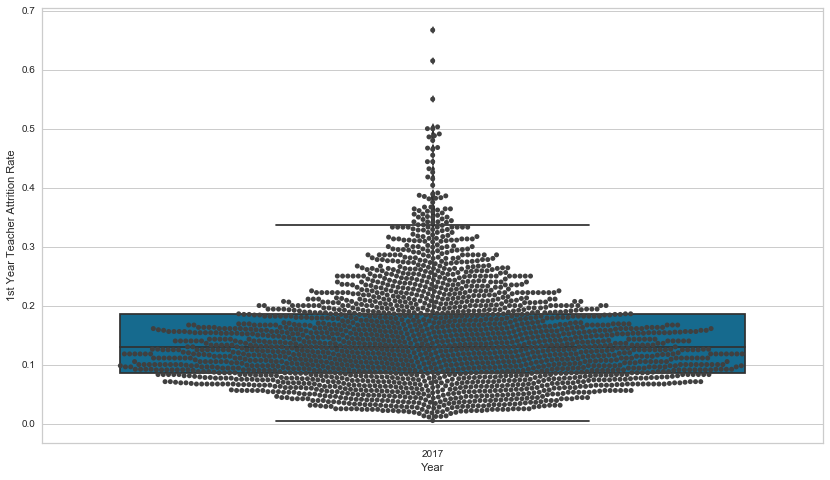

In [25]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData)
ax = sns.swarmplot(x="Year", y="_1yr_tchr_trnovr_pct", data=schData, color=".25")
plt.ylabel('1st Year Teacher Attrition Rate')
plt.xlabel('Year')
plt.savefig('Figure3.png')

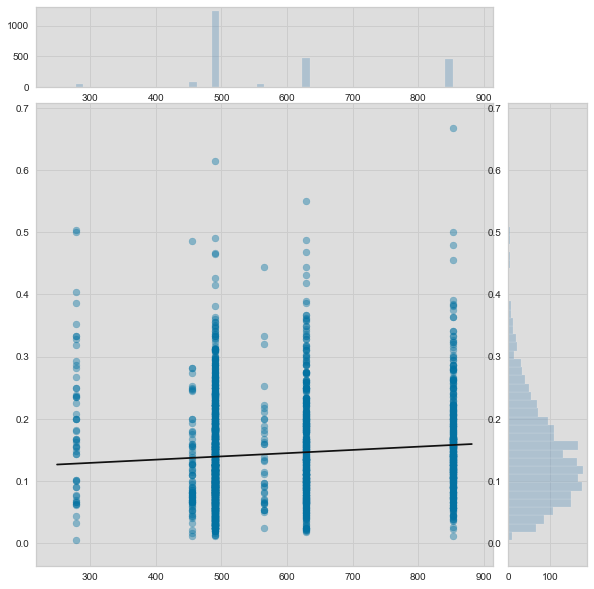

In [27]:
feature = "st_avg_student_num"
target = "_1yr_tchr_trnovr_pct"

# Get the X and y data from the DataFrame
X_feature = schData[feature]
y_feature = schData[target]



visualizer = JointPlotVisualizer(feature=feature, target=target)

visualizer.fit(X_feature, y_feature)
visualizer.poof()


In [28]:
#schData.info(verbose=True)

## Feature Selection
* set max features we want to select

### Manually remove columns

* there columns is not what we are interested in, so we remove them manaually from data set

In [29]:
# manually remove the columns

ManualDropFeatures = ['st_1yr_tchr_trnovr_pct','lea_1yr_tchr_trnovr_pct','PacificIslandPct','PacificIslandMalePct','PacificIslandFemalePct','HispanicPct'
                      ,'BlackPct','AsianPct','IndianPct','WhitePct','TwoOrMorePct','TwoOrMoreMalePct','TwoOrMoreFemalePct'

                      ,'lea_supplies_expense_pct'
                      ,'lea_services_expense_pct','lea_salary_expense_pct','lea_total_expense_num'
                      #,'lea_benefits_expense_pct'                    
                     ]

schData = schData.drop(ManualDropFeatures,axis=1)
print('*********After: Removing fetures we are not interested in ******')
schData.info(verbose=False)
print ('\r\nFeatures Deleted: ', len(ManualDropFeatures))

*********After: Removing fetures we are not interested in ******
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2467
Columns: 379 entries, student_num to unit_code
dtypes: float64(334), int64(45)
memory usage: 6.8 MB

Features Deleted:  17


## These features have big number of the weight in feature selection, trying to remove them and see if it will be better

In [30]:
# schData = schData.drop(['Number of farm returns All','Number of farm returns 100KLT200K',
# 'Number of farm returns LT25K',
# 'Number of farm returns 25KLT50K',
# 'Number of farm returns 50KLT75K',
# 'Number of farm returns 75KLT100K',
# 'Number of farm returns GE200K'],axis=1)

In [31]:
schData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2467
Columns: 379 entries, student_num to unit_code
dtypes: float64(334), int64(45)
memory usage: 6.8 MB


## Transformation

In [32]:
# Get the X and y
y= schData['_1yr_tchr_trnovr_pct']
X = schData.drop(['_1yr_tchr_trnovr_pct'],axis=1)

In [33]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 1 to 2467
Columns: 378 entries, student_num to unit_code
dtypes: float64(333), int64(45)
memory usage: 6.8 MB


In [34]:
# Transform

saved_cols = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
#Save as data frames
X = pd.DataFrame(X)
X.columns = saved_cols


C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [35]:
# threthold for the feature selection
max_features =200
# backup the data set
schData_bak = schData
#schData = schData_bak

In [36]:
# Feature Selection 
X_fs = X
y_fs = y


## Pearson Correlation

In [37]:
# Pearson Correlation
feature_name = X_fs.columns.tolist()
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        # replace NaN with 0
        cor_list = [0 if np.isnan(i) else i for i in cor_list]
        # feature name
        cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-max_features:]].columns.tolist()
        # feature selection? 0 for not select, 1 for select
        cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_fs, y_fs)
print(str(len(cor_feature)), 'selected features')
print(pd.DataFrame( cor_feature))

C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


200 selected features
                                                     0
0                    Add child tax credit Amt 25KLT50K
1                                   tchyrs_4thru10_pct
2                                        category_cd_H
3                  (TCE) prepared returns Ct 75KLT100K
4                          EOGReadingGr5_CACR_Hispanic
5                               SBE District_Northwest
6                           Deductible points Ct LT25K
7             Tuition and fees deduction Amt 75KLT100K
8                           10+ Years_LEA_Exp_Pct_Prin
9                              lea_long_susp_per_c_num
10                                   EOGGr3_CACR_Black
11                                   EOGGr5_CACR_Asian
12   Domestic production activities deduction Ct 25...
13   Partnership/S-corp net income (less loss) Amt ...
14                               st_expelled_per_c_num
15       Other non-limited misc deduction Amt 50KLT75K
16               Investment interest paid A

## Linear Reggesion RFE

In [38]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=max_features, step=10, verbose=5)
rfe_selector.fit(X_fs, y_fs)
rfe_support = rfe_selector.get_support()
rfe_feature = X_fs.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(pd.DataFrame(rfe_feature))

Fitting estimator with 378 features.
Fitting estimator with 368 features.
Fitting estimator with 358 features.
Fitting estimator with 348 features.
Fitting estimator with 338 features.
Fitting estimator with 328 features.
Fitting estimator with 318 features.
Fitting estimator with 308 features.
Fitting estimator with 298 features.
Fitting estimator with 288 features.
Fitting estimator with 278 features.
Fitting estimator with 268 features.
Fitting estimator with 258 features.
Fitting estimator with 248 features.
Fitting estimator with 238 features.
Fitting estimator with 228 features.
Fitting estimator with 218 features.
Fitting estimator with 208 features.
200 selected features
                                                     0
0                                          student_num
1                                  lea_avg_student_num
2                                   st_avg_student_num
3                                              02_Size
4                                    

## Linear Regression

In [39]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression

Linear = LinearRegression()

Linear_selector = SelectFromModel(Linear, threshold='1.25*median', max_features=max_features)
Linear_selector.fit(X_fs, y_fs)
Linear_support = Linear_selector.get_support()
Linear_feature = X_fs.loc[:,Linear_support].columns.tolist()
print(str(len(Linear_feature)), 'selected features')
print(pd.DataFrame(Linear_feature))

164 selected features
                                                     0
0                                  lea_avg_student_num
1                                   st_avg_student_num
2                                              03_Size
3                           lea_instruct_equip_exp_pct
4                                   EVAAS Growth Score
5                             EOG/EOCSubjects_CACR_All
6                                      EOGGr4_CACR_All
7                                 EOCMathI_CACR_Female
8                                EOGMathGr3_CACR_Black
9                                EOGMathGr4_CACR_Black
10                            EOGReadingGr3_CACR_Black
11                            EOGReadingGr4_CACR_Black
12                            EOGReadingGr5_CACR_Black
13                            EOGMathGr5_CACR_Hispanic
14                       EOGReadingGr3-8_CACR_Hispanic
15                           EOGSubjects_CACR_Hispanic
16                    EOGMathGr3-8_CACR_Two

## Lasso

In [40]:

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

from sklearn.linear_model import Ridge

LassoCV = LassoCV(cv = 10,tol=0.1)

LassoCV_selector = SelectFromModel(LassoCV, threshold='1.25*median', max_features=max_features)
LassoCV_selector.fit(X_fs, y_fs)
LassoCV_support = LassoCV_selector.get_support()
LassoCV_feature = X_fs.loc[:,LassoCV_support].columns.tolist()
print(str(len(LassoCV_feature)), 'selected features')
print(pd.DataFrame(LassoCV_feature))

200 selected features
                                                     0
0                                          student_num
1                                  lea_avg_student_num
2                                   st_avg_student_num
3                                              00_Size
4                                              02_Size
5                                              03_Size
6                                              04_Size
7                                              05_Size
8                                          Math I_Size
9                           lea_instruct_equip_exp_pct
10                            lea_federal_perpupil_num
11                              lea_local_perpupil_num
12                              lea_state_perpupil_num
13                                           SPG Score
14                                   Reading SPG Score
15                                  EVAAS Growth Score
16                                       Sc

## Ridge Regression

In [41]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge

reg = Ridge()

reg_selector = SelectFromModel(reg, threshold='1.25*median', max_features=max_features)
reg_selector.fit(X_fs, y_fs)
reg_support = reg_selector.get_support()
reg_feature = X_fs.loc[:,reg_support].columns.tolist()
print(str(len(reg_feature)), 'selected features')
print(pd.DataFrame(reg_feature))

162 selected features
                                                     0
0                                          student_num
1                                  lea_avg_student_num
2                                              03_Size
3                                              04_Size
4                               lea_local_perpupil_num
5                                            SPG Score
6                                    Reading SPG Score
7                                   EVAAS Growth Score
8                                        Science Score
9                                      NC Math 1 Score
10                            EOG/EOCSubjects_CACR_All
11                                     EOGGr3_CACR_All
12                                     EOGGr4_CACR_All
13                                EOCMathI_CACR_Female
14                      EOGMathGr4_CACR_AmericanIndian
15                   EOGReadingGr4_CACR_AmericanIndian
16                    EOGReadingGr5_GLP_Ame

## Elastic Net Regression

In [42]:
from sklearn.linear_model import ElasticNet

ELN = ElasticNet()

ELN_selector = SelectFromModel(ELN, threshold='1.25*median', max_features=max_features)
ELN_selector.fit(X_fs, y_fs)
ELN_support = ELN_selector.get_support()
ELN_feature = X_fs.loc[:,ELN_support].columns.tolist()
print(str(len(ELN_feature)), 'selected features')
print(pd.DataFrame(ELN_feature))


200 selected features
                                       0
0                            student_num
1                    lea_avg_student_num
2                     st_avg_student_num
3                                00_Size
4                                02_Size
5                                03_Size
6                                04_Size
7                                05_Size
8                            Math I_Size
9             lea_instruct_equip_exp_pct
10              lea_federal_perpupil_num
11                lea_local_perpupil_num
12                lea_state_perpupil_num
13                             SPG Score
14                     Reading SPG Score
15                    EVAAS Growth Score
16                         Science Score
17                       NC Math 1 Score
18              EOG/EOCSubjects_CACR_All
19                       EOGGr3_CACR_All
20                       EOGGr4_CACR_All
21                       EOGGr5_CACR_All
22                  EOCMathI_CACR_F

In [43]:
## Summary
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name
                                     , 'Pearson':cor_support
                                     , 'Linear Regression':Linear_support
                                     , 'RFE':rfe_support
                                     , 'Lasso':LassoCV_support
                                     ,'Ridge':reg_support
                                     , 'Elastic Net':ELN_support
                                     
                                    })
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] ,
ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

,Feature,Pearson,Linear Regression,RFE,Lasso,Ridge,Elastic Net,Total
1,lea_ap_participation_pct,True,True,True,True,True,True,6
2,MathGr3-8_pTarget_PctMet,True,True,True,True,True,True,6
3,EVAAS Growth Score,True,True,True,True,True,True,6
4,EOGScienceGr5&8_CACR_EDS,True,True,True,True,True,True,6
5,EOGGr4_CACR_All,True,True,True,True,True,True,6
6,EOG/EOCSubjects_CACR_EDS,True,True,True,True,True,True,6
7,03_Size,True,True,True,True,True,True,6
8,tchyrs_11plus_pct,True,True,True,True,True,False,5
9,tchyrs_0thru3_pct,True,True,True,True,True,False,5
10,student_num,True,False,True,True,True,True,5


In [44]:
# export feature selection to csv file
feature_selection_df.to_csv('Feature_Selection_Results_2017.csv', sep=',', index=False)

In [45]:
feature_to_remove = feature_selection_df[feature_selection_df['Total']<3]['Feature']
X = X.drop(feature_to_remove, axis=1)

#feature_to_remove
print ('\r\nFeatures Deleted: ', len(feature_to_remove))


Features Deleted:  151


In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Columns: 227 entries, student_num to unit_code
dtypes: float64(227)
memory usage: 4.0 MB


## RFE Feature Importance

In [47]:
# %%time

# df2_vif = pd.DataFrame()
# df2_vif["VIF Factor"] = [vif(X.values, i) for i in range(X.shape[1])]
# df2_vif["ABSVIFFactor"] = abs(df2_vif["VIF Factor"])
# df2_vif["features"] = X.columns
# df2_vif["indexes"] = range(0, len(X.columns))

In [48]:
# df2_vif = df2_vif.sort_values('ABSVIFFactor', ascending=True)
# df2_vif.to_csv('VIF_Result_ML.csv', sep=',', index=False)

In [49]:
# %%time



# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#     test_size=0.3,random_state =1 )

# #print("RFE CV Linear Regression 1st Pass")
# rfecvEstimator = LinearRegression()

# parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

# #Create a grid search object  

# grid = GridSearchCV(estimator=rfecvEstimator
#                    #, n_jobs=8 # jobs to run in parallel
#                    #, verbose=0 # low verbosity
#                    , param_grid=parameters
#                   )

# #Perform hyperparameter search to find the best combination of parameters for our data using RFECV
# grid.fit(X_train, y_train)
# print("r2 / variance : ", grid.best_score_)
# print("Residual sum of squares: %.2f"
#               % np.mean((grid.predict(X_test) - y_test) ** 2))

In [50]:

#Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

In [51]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score 
#from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_scorer 

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
# revised from - https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
# still not working
def mape(y_actual, y_predicted): 
    mask = y_actual != 0           
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100
# Credit: https://alex.miller.im/posts/linear-model-custom-loss-function-regularization-python/
def mean_absolute_percentage_error(y_true, y_pred, sample_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        if type(sample_weights) != type(None):
            sample_weights = np.array(sample_weights)
            sample_weights = np.delete(sample_weights, idx)
        
    if type(sample_weights) == type(None):
        return(np.mean(np.abs((y_true - y_pred) / y_true)))
    else:
        sample_weights = np.array(sample_weights)
        assert len(sample_weights) == len(y_true)
        return(100/sum(sample_weights)*np.dot(
                sample_weights, (np.abs((y_true - y_pred) / y_true))
        ))
    
#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(score_func=mean_squared_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
#mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True) 

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'MSE':  mse_scorer, 
                'RMSE': rmse_scorer,
                #'MAPE': mape_scorer,
                'R2': r2_scorer       
               } 

In [52]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MSE'] = scores['test_MSE'] * -1
    #scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

     #print mean MAE for all folds 
    mseAvg = scores['test_MSE'].mean()
    print_str = "The average MSE for all cv folds is: \t\t\t {mseAvg:.5}"
    print(print_str.format(mseAvg=mseAvg))
    
    #print mean test_MAPE for all folds
#     scores['test_MAPE'] = scores['test_MAPE']
#     mape_avg = scores['test_MAPE'].mean()
#     print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
#     print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')
    
    #print mean R-squared for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R-Squared for all cv folds is: \t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('*********************************************************')


    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MSE'] = scores['test_MSE']
   # scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    return scoresResults


In [53]:
%%time


print("RFE CV Linear Regression 1st Pass")
rfecvEstimator = LinearRegression()

parameters = { 'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]
             }

#Create a grid search object  
#from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                  , verbose=0 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   )

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(X, y)

#Use the best parameters for our RFECV Linear Regression object
rfecvLinearEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvLinearEst, step=1, cv=cv,  verbose=1)
X_BestFeatures = rfecv.fit_transform(X, y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

print("Linear Regression Second Pass")
#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LinearRegression())

#Define a range of hyper parameters for grid search
parameters = { 'linearregression__fit_intercept':[True,False], 'linearregression__normalize':[True,False]
              , 'linearregression__copy_X':[True, False]
              , 'linearregression__n_jobs':[None]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(estimator=pipe, param_grid=parameters, cv=cv)

#Use the best features from recursive feature elimination during the grid search
grid.fit(X, y)


RFE CV Linear Regression 1st Pass
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitt

Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
F

Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
F

Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
F

Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
F

Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
F

Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
F

Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
F

Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
F

Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
Fitting estimator with 215 features.
Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
F

Fitting estimator with 215 features.
Fitting estimator with 214 features.
Ranking [ 1  1  1  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  9 13  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12
  1  1  1  1  3  1  1  1 15 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  4  6  1  1  1  1  1  1  1  2  1  1  8  1  1  1  1  1  1  1  1  1  1 14
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 11  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  5  1  1  1  1  1  1]
Support [ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False  True  True  True

In [54]:
#Print the parameterization of the best estimator
regEstimator = grid.best_estimator_

RFE_Results = EvaluateRegressionEstimator(regEstimator, X_BestFeatures, y, cv)

The average MAE for all cv folds is: 			 0.04982
The average MSE for all cv folds is: 			 0.00433
The average RMSE for all cv folds is: 			 0.065763
*********************************************************
The average R-Squared for all cv folds is: 		 0.34395
*********************************************************
Cross Validation Fold Mean Error Scores


In [55]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = regEstimator.named_steps['linearregression'].coef_.ravel()#[rfecv.get_support(indices=True)]
feature_names = X.columns#.values[rfecv.get_support(indices=True)]
#print(weights)

In [56]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
#weights = grid.best_estimator_.named_steps['linearregression'].coef_.ravel()
#feature_names = X.columns#.values[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights,
                                 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

#Print out all the missing value rows
pd.set_option('display.max_rows', 1000)

#linreg_ft_imp_df = linreg_ft_imp_df[linreg_ft_imp_df.feature_names != 'SchoolYear']

model_features = len(linreg_ft_imp_df.index)
print('Total Model Features: ' + str(model_features))

#Print all of the features selected by the model 
linreg_ft_imp_df


Total Model Features: 227


,feature_names,weights,absolute_weights
2,st_avg_student_num,5.845543e+10,5.845543e+10
122,st_expelled_per_c_num,4.796244e+10,4.796244e+10
215,category_cd_H,-4.786979e+10,4.786979e+10
121,st_long_susp_per_c_num,-4.624804e+10,4.624804e+10
135,st_emer_prov_teach_pct,-2.434242e+10,2.434242e+10
195,Number of farm returns All,-1.826812e+10,1.826812e+10
214,category_cd_E,1.135446e+10,1.135446e+10
191,Number of farm returns 100KLT200K,7.343049e+09,7.343049e+09
134,st_tchyrs_11plus_pct,5.751113e+09,5.751113e+09
119,st_crime_per_c_num,4.866380e+09,4.866380e+09


Total Model Features: 50


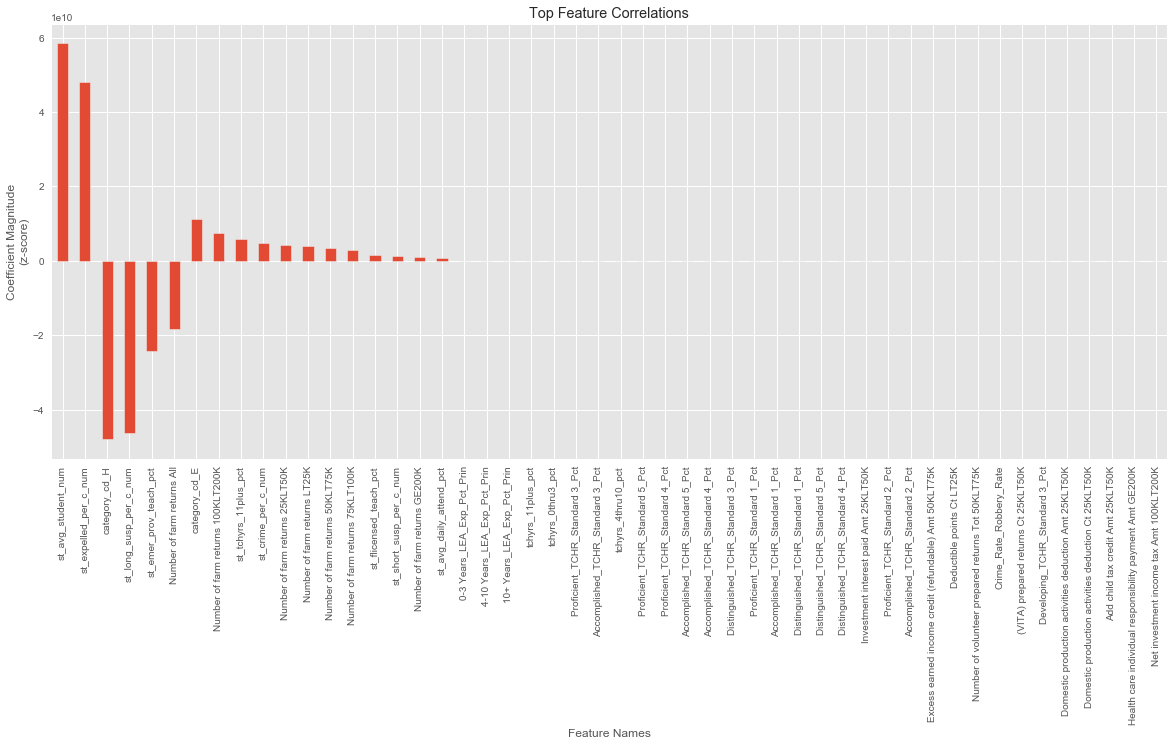

In [57]:
#Get the top 75 coefficients
wt_plt_df = linreg_ft_imp_df.head(50)

model_features = len(wt_plt_df.index)
print('Total Model Features: ' + str(model_features))

# Examine categorical variables of interest  
# import matplotlib.pyplot as plt
# %matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

In [58]:
# export feature selection to csv file
linreg_ft_imp_df.to_csv('RFE_Feature_Importance_Results_2017.csv', sep=',', index=False)

In [59]:
linreg_ft_imp_df50 = linreg_ft_imp_df.head(50)
linreg_ft_imp_df50.columns

Index(['feature_names', 'weights', 'absolute_weights'], dtype='object')

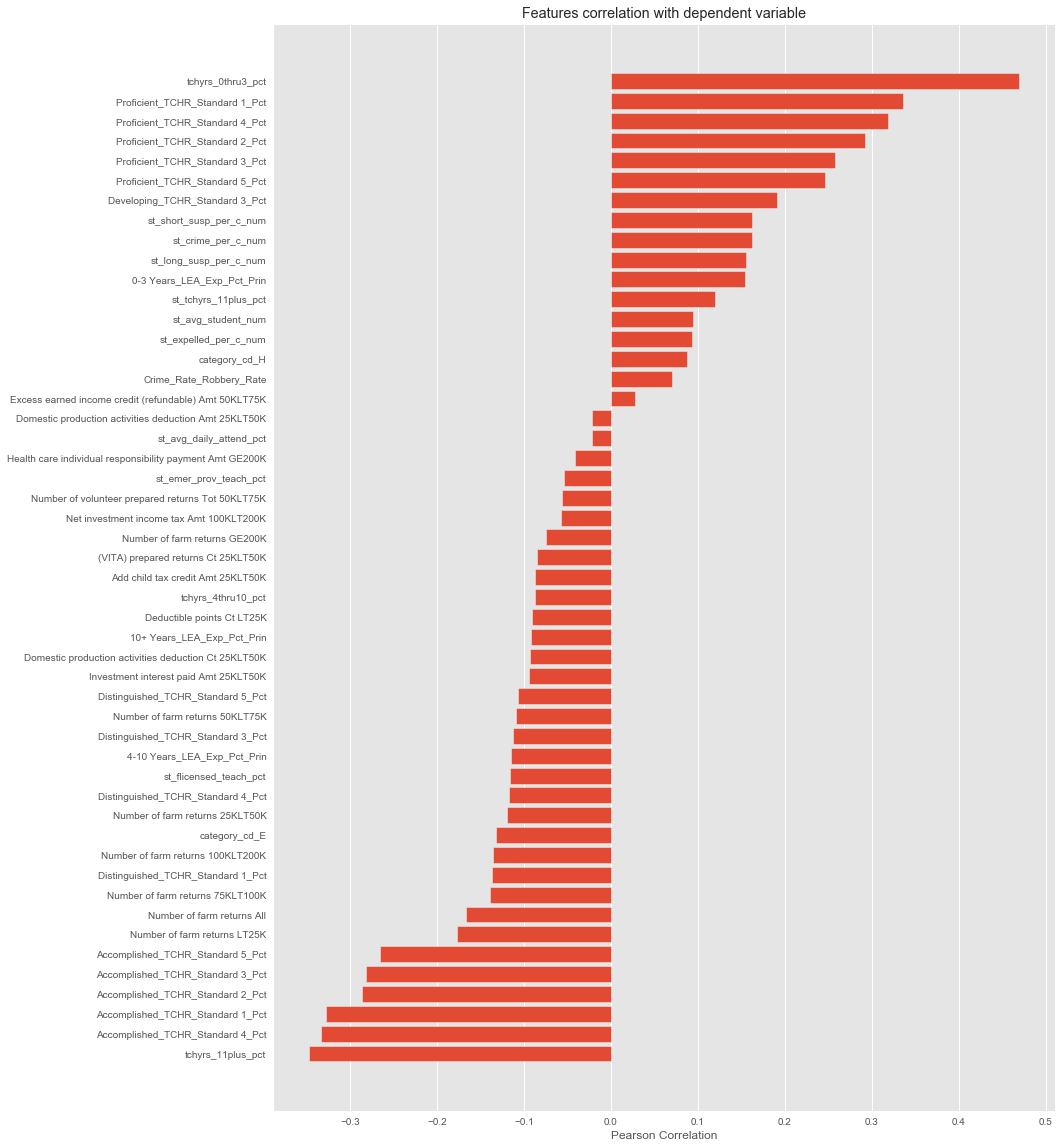

In [60]:
from yellowbrick.target import FeatureCorrelation

# Load the regression data set

feature_names = np.array(linreg_ft_imp_df50.feature_names)

X_feature = X[linreg_ft_imp_df50.feature_names]

fig = plt.figure(figsize=(14, 20))
ax = fig.add_subplot()

visualizer = FeatureCorrelation(labels=feature_names,sort=True)
visualizer.fit(X_feature, y)
visualizer.poof()

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [61]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =1 )

## Custom Scorers for Evaluating Regression Models 

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
* Mean Absolute Percentage Error (MAPE) - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python

**For details on making scorers to return multiple mean error scores see:**
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
* https://github.com/scikit-learn/scikit-learn/pull/7388
* https://github.com/drorata/multiscorer

In [62]:
# it may not make sense to use MAPE in our project based on below articles:
# http://www.catchbull.com/catchblogs/why-mape-doesnt-work


## Regression Model Evaluation
** All regression models are evaluated using the regression model evaluation function below: ** 
* The following regression evaluation function uses the cross validation object and the custom scorers in the two cells above in combination with sklearn.model_selection's cross_validate function to perform cross validation for regression estimators.
* The cross validation object above uses a random seed to ensure that all regression estimators are tested on the same randomly selected records for each cross validation fold.
* Custom scorers are created using the three chosen mean error scores and passed into cross_validate(), so all three scores are calcualted using a single call to cross_validate().
* All of this functionality is wrapped within the custom EvaluateRegressionEstimator() function below so multiple regression models may be tested using the same test / train cv data and evaluation scores producing a consistent output for each model without the need to re-write the same code over and over. 

## Baseline Regression Model

**Linear Regression is used to create a baseline model.  Since linear regression may predict response variable values outside the range of the training data's response variable, we create a linear regression estimator with graduation rate predictions clipped 0% and 100%. For details see:**
* http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator 
* https://github.com/scikit-learn/scikit-learn/issues/6950
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://github.com/scikit-learn-contrib/project-template/blob/master/skltemplate/template.py
* https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion

In [63]:
#Make new estimator compatible for use with GridSearchCV() and cross_validate()
# -  Cap predict function for LinearRegression between 0 and 100
# -  See: Roll your own estimator links above for details. 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 0, 100) 

### Linear Regression Grid Search
** Here we perform a grid search testing 40 models to find the best parameters for our Linear Regression model based on Mean Absolute Error.  See more on parameter tuning with grid search here:**
* http://scikit-learn.org/stable/modules/grid_search.html

In [64]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False),'normalize': (True, False),}

#Create a grid search object using the  
linregGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#linregGridSearch hyperparameter search to find the best combination of parameters for our data
linregGridSearch.fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
            normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [65]:
#Print the parameterization of the best estimator
linregEstimator = linregGridSearch.best_estimator_
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
CappedLinear_Results = EvaluateRegressionEstimator(linregEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.050292
The average MSE for all cv folds is: 			 0.0043669
The average RMSE for all cv folds is: 			 0.066042
*********************************************************
The average R-Squared for all cv folds is: 		 0.33827
*********************************************************
Cross Validation Fold Mean Error Scores


In [66]:
linregEstimator = linregGridSearch.best_estimator_

linregEstimator.fit(X_train, y_train)
linregyhat = linregEstimator.predict(X_test)
print("Yhat Max: ", linregyhat.max())
print(explained_variance_score(y_test,linregyhat, multioutput='uniform_average'))

Yhat Max:  0.3487309628325996
0.3279178604648453


## Support Vector Regression
**This model uses Support Vector Machines for regression of continuous variables (SVR). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
* http://scikit-learn.org/stable/modules/svm.html

In [67]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
svr = SVR()

#Set up SVR parameters to test (WARNING: Creates 320 models!!!) 
costs = [0.001, 0.1]
defGamma = 1 / X.shape[1]  #This is the default value for the gamma parameter
gammas = [defGamma, 0.1]
kernels = ['rbf','linear']
parameters = {'C': costs, 'gamma' : gammas, 'kernel': kernels}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
svrGridSearch = GridSearchCV(estimator=svr
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
svrGridSearch.fit(X, y)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:   16.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'C': [0.001, 0.1], 'gamma': [0.004405286343612335, 0.1], 'kernel': ['rbf', 'linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [68]:
#Display the best estimator parameters
svrGridSearch.best_estimator_

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.004405286343612335, kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [69]:
# from sklearn.svm import SVR

#Create a regression estimator with best parameters for cross validation
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svrEstimator = svrGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
SVR_Results=EvaluateRegressionEstimator(svrEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.052884
The average MSE for all cv folds is: 			 0.0046512
The average RMSE for all cv folds is: 			 0.068164
*********************************************************
The average R-Squared for all cv folds is: 		 0.2944
*********************************************************
Cross Validation Fold Mean Error Scores


In [ ]:
#Do we predict graduation rates greater than 100%?
# regEstimator = SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#                    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svrEstimator.fit(X_train, y_train)
svr_yhat = svrEstimator.predict(X_test)
print("Yhat Max: ", svr_yhat.max())
print(explained_variance_score(y_test,svr_yhat, multioutput='uniform_average'))

Yhat Max:  0.3319050900970334
0.32474631373915464


## Teacher Attrition Rate - Lasso Regression
**This model uses Lasso regression (L1 Norm). Please see documentation here:"**
* **Caution!** - See documentation for fit_intercept, normalize, and copy_X. Lasso can over-write your X data!
* Lasso may also perform scaling as well.  Please see docs!
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [ ]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

lasso = Lasso()

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
lassoGridSearch = GridSearchCV(estimator=lasso
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
lassoGridSearch.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'alpha': [0.001, 0.1, 1, 10, 20], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [ ]:
#Display the best estimator parameters
lassoGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=True)

In [ ]:
#Create a regression estimator with best parameters for cross validation
lassoEstimator =lassoGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Lasso_Results = EvaluateRegressionEstimator(lassoEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.049657
The average MSE for all cv folds is: 			 0.004292
The average RMSE for all cv folds is: 			 0.065473
*********************************************************
The average R-Squared for all cv folds is: 		 0.35003
*********************************************************
Cross Validation Fold Mean Error Scores


In [ ]:
#Do we predict graduation rates greater than 100%?
# regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
#    normalize=True, positive=False, precompute=True, random_state=0,
#    selection='cyclic', tol=0.0001, warm_start=True)
lassoEstimator = lassoGridSearch.best_estimator_

lassoEstimator.fit(X_train, y_train)
Lasso_yhat = lassoEstimator.predict(X_test)
print("Yhat Max: ", Lasso_yhat.max())
print(explained_variance_score(y_test,Lasso_yhat, multioutput='uniform_average'))

Yhat Max:  0.32143810353815183
0.35999865898045147


## Ridge Regression
**This model uses Ridge regression (L2 Norm). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [ ]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

ridge = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
#from sklearn.model_selection import GridSearchCV
ridgeGridSearch = GridSearchCV(estimator=ridge
                   , n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
ridgeGridSearch.fit(X, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 206 tasks      | elapsed:   45.3s
[Parallel(n_jobs=10)]: Done 341 out of 360 | elapsed:   48.7s remaining:    2.6s
[Parallel(n_jobs=10)]: Done 360 out of 360 | elapsed:  1.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=0, solver='auto', tol=0.0001),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [ ]:
#Display the best estimator parameters
ridgeGridSearch.best_estimator_

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=True, random_state=0, solver='svd', tol=0.0001)

In [ ]:
%%time
#Create a regression estimator with best parameters for cross validation
ridgeEstimator = ridgeGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
Ridge_Results = EvaluateRegressionEstimator(ridgeEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.049151
The average MSE for all cv folds is: 			 0.0042212
The average RMSE for all cv folds is: 			 0.06494
*********************************************************
The average R-Squared for all cv folds is: 		 0.36024
*********************************************************
Cross Validation Fold Mean Error Scores
Wall time: 680 ms


In [ ]:
#Do we predict graduation rates greater than 100%?
# regEstimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
#    normalize=True, random_state=0, solver='saga', tol=0.0001)
ridgeEstimator = ridgeGridSearch.best_estimator_

ridgeEstimator.fit(X_train, y_train)
ridge_yhat = ridgeEstimator.predict(X_test)
print("Yhat Max: ", ridge_yhat.max())
print(explained_variance_score(y_test,ridge_yhat))

Yhat Max:  0.3400386512403235
0.358142616003867


## Elastic Net Regression
**This model uses Elastic Net Regression (L1 and L2 Norm mixing). Please see documentation here:"**
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [ ]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
elasticNetGridSearch = GridSearchCV(estimator=elasticNet
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
elasticNetGridSearch.fit(X, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 658 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:    7.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'alpha': [0.001, 0.1, 1, 10], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [ ]:
#Display the best estimator parameters
elasticNetGridSearch.best_estimator_

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.001,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='random', tol=0.0001, warm_start=True)

In [ ]:
#Create a regression estimator with best parameters for cross validation
elasticNetEstimator = elasticNetGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
elastic_Results = EvaluateRegressionEstimator(elasticNetEstimator, X, y, cv)

The average MAE for all cv folds is: 			 0.050832
The average MSE for all cv folds is: 			 0.0044266
The average RMSE for all cv folds is: 			 0.066479
*********************************************************
The average R-Squared for all cv folds is: 		 0.33071
*********************************************************
Cross Validation Fold Mean Error Scores


In [ ]:
#Do we predict graduation rates greater than 100%?
elasticNetEstimator =  elasticNetGridSearch.best_estimator_

elasticNetEstimator.fit(X_train, y_train)
elasticNet_yhat = elasticNetEstimator.predict(X_test)
print("Yhat Max: ", elasticNet_yhat.max())
print(explained_variance_score(y_test,elasticNet_yhat, multioutput='uniform_average'))

Yhat Max:  0.3021694588674327
0.35698654317093503


## XGBoost

In [ ]:
# credit: https://www.kaggle.com/mburakergenc/predictions-with-xgboost-and-linear-regression
#credit: https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
# https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv
# Various hyper-parameters to tune
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgbGridSearch = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgbGridSearch.fit(X_train,
         y_train)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory lea

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'nthread': [4], 'objective': ['reg:linear'], 'learning_rate': [0.03, 0.05, 0.07], 'max_depth': [5, 6, 7], 'min_child_weight': [4], 'silent': [1], 'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [ ]:
#Display the best estimator parameters
xgbGridSearch.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, importance_type='gain',
       learning_rate=0.03, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=500, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)

In [ ]:
#Create a regression estimator with best parameters for cross validation
xgbEstimator = xgbGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
xgb_Results = EvaluateRegressionEstimator(xgbEstimator, X, y, cv)

C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\yubin\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future

In [ ]:
#Do we predict graduation rates greater than 100%?
xgbEstimator =  elasticNetGridSearch.best_estimator_

xgbEstimator.fit(X_train, y_train)
xgb_yhat = xgbEstimator.predict(X_test)
print("Yhat Max: ", xgb_yhat.max())
print(explained_variance_score(y_test,xgb_yhat, multioutput='uniform_average'))

## Residuals Plot

In [ ]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()

ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [ ]:


from yellowbrick.regressor import PredictionError

# Instantiate the linear model and visualizer

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot()


visualizer = PredictionError(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()     